# HEOM 5a: Fermionic single impurity model

## Introduction

Here we model a single fermion coupled to two electronic leads or reservoirs (e.g.,  this can describe a single quantum dot, a molecular transistor, etc).  Note that in this implementation we primarily follow the definitions used by Christian Schinabeck in his dissertation https://open.fau.de/items/36fdd708-a467-4b59-bf4e-4a2110fbc431 and related publications.

Notation:

* $K=L/R$ refers to  left or right leads.
* $\sigma=\pm$ refers to input/output

We choose a Lorentzian spectral density for the leads, with a peak at the chemical potential. The latter simplifies a little the notation required for the correlation functions, but can be relaxed if neccessary.

$$J(\omega) = \frac{\Gamma  W^2}{((\omega-\mu_K)^2 +W^2 )}$$

The Fermi distribution function is:

$$f_F (x) = (\exp(x) + 1)^{-1}$$

Together these allow the correlation functions to be expressed as:

$$C^{\sigma}_K(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} d\omega e^{\sigma i \omega t} \Gamma_K(\omega) f_F[\sigma\beta(\omega - \mu)]$$

As with the bosonic case we can expand these in an exponential series using Matsubara, Pade, or fitting approaches.

The Pade decomposition approximates the Fermi distubition as

$$f_F(x) \approx f_F^{\mathrm{approx}}(x) = \frac{1}{2} - \sum_l^{l_{max}} \frac{2k_l x}{x^2 + \epsilon_l^2}$$

where $k_l$ and $\epsilon_l$ are co-efficients defined in J. Chem Phys 133,10106.

Evaluating the integral for the correlation functions gives,

$$C_K^{\sigma}(t) \approx \sum_{l=0}^{l_{max}} \eta_K^{\sigma_l} e^{-\gamma_{K,\sigma,l}t}$$

where:

$$\eta_{K,0} = \frac{\Gamma_KW_K}{2} f_F^{approx}(i\beta_K W)$$

$$\gamma_{K,\sigma,0} = W_K - \sigma i\mu_K$$ 

$$\eta_{K,l\neq 0} = -i\cdot \frac{k_m}{\beta_K} \cdot \frac{\Gamma_K W_K^2}{-\frac{\epsilon^2_m}{\beta_K^2} + W_K^2}$$

$$\gamma_{K,\sigma,l\neq 0}= \frac{\epsilon_m}{\beta_K} - \sigma i \mu_K$$

In this notebook we:

* compare the Matsubara and Pade approximations and contrast them with the analytical result for the current between the system and the leads.

* plot the current through the qubit as a function of the different between the voltages of the leads.

## Setup

In [1]:
import contextlib
import dataclasses
import time

import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

from qutip import about, basis, destroy, expect
from qutip.core.environment import LorentzianEnvironment
from qutip.solver.heom import HEOMSolver

from IPython.display import display
from ipywidgets import IntProgress

%matplotlib inline

## Helpers

In [2]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [3]:
# Solver options:

# We set store_ados to True so that we can
# use the auxilliary density operators (ADOs)
# to calculate the current between the leads
# and the system.

options = {
    "nsteps": 1500,
    "store_states": True,
    "store_ados": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

In [4]:
# Define the system Hamiltonian:

# The system is a single fermion with energy level split e1:
d1 = destroy(2)
e1 = 1.0
H = e1 * d1.dag() * d1

In [5]:
# Define parameters for left and right fermionic baths.
# Each bath is a lead (i.e. a wire held at a potential)
# with temperature T and chemical potential mu.

@dataclasses.dataclass
class LorentzianBathParameters:
    lead: str
    Q: object  # coupling operator
    gamma: float = 0.01  # coupling strength
    W: float = 1.0  # cut-off
    T: float = 0.025851991  # temperature
    theta: float = 2.0  # bias

    def __post_init__(self):
        assert self.lead in ("L", "R")
        self.beta = 1 / self.T
        if self.lead == "L":
            self.mu = self.theta / 2.0
        else:
            self.mu = -self.theta / 2.0

    def J(self, w):
        """ Spectral density. """
        return self.gamma * self.W**2 / ((w - self.mu)**2 + self.W**2)

    def fF(self, w, sign=1.0):
        """ Fermi distribution for this bath. """
        x = sign * self.beta * (w - self.mu)
        return fF(x)

    def lamshift(self, w):
        """ Return the lamb shift. """
        return 0.5 * (w - self.mu) * self.J(w) / self.W

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)


def fF(x):
    """ Return the Fermi distribution. """
    # in units where kB = 1.0
    return 1 / (np.exp(x) + 1)


bath_L = LorentzianBathParameters(Q=d1, lead="L")
bath_R = LorentzianBathParameters(Q=d1, lead="R")

## Spectral density

Let's plot the spectral density.

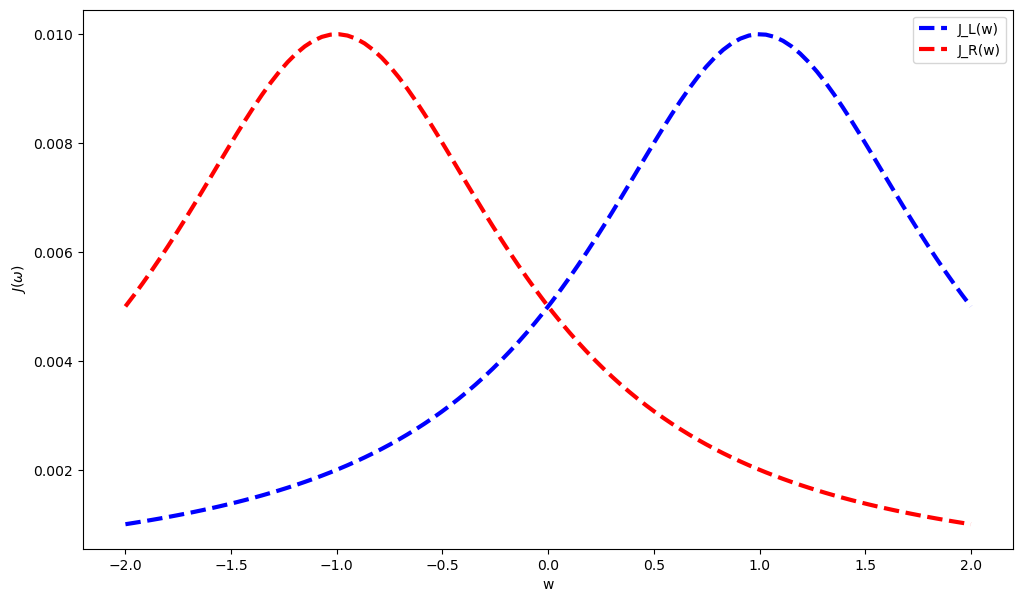

In [6]:
w_list = np.linspace(-2, 2, 100)

fig, ax = plt.subplots(figsize=(12, 7))

spec_L = bath_L.J(w_list)
spec_R = bath_R.J(w_list)

ax.plot(
    w_list, spec_L,
    "b--", linewidth=3,
    label=r"J_L(w)",
)
ax.plot(
    w_list, spec_R,
    "r--", linewidth=3,
    label=r"J_R(w)",
)

ax.set_xlabel("w")
ax.set_ylabel(r"$J(\omega)$")
ax.legend();

## Emission and absorption by the leads

Next let's plot the emission and absorption by the leads.

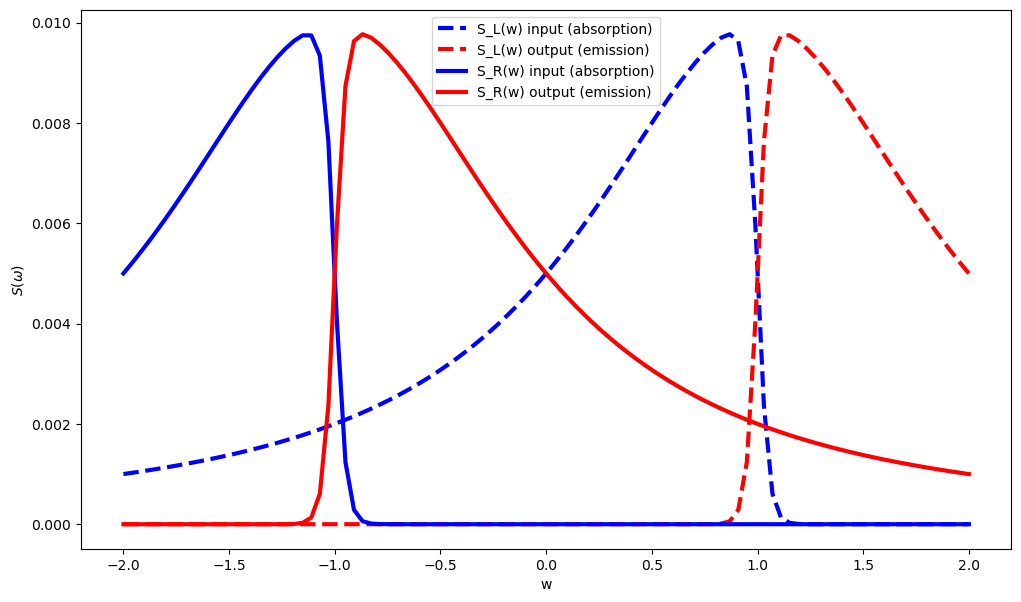

In [7]:
w_list = np.linspace(-2, 2, 100)

fig, ax = plt.subplots(figsize=(12, 7))

# Left lead emission and absorption

gam_L_in = bath_L.J(w_list) * bath_L.fF(w_list, sign=1.0)
gam_L_out = bath_L.J(w_list) * bath_L.fF(w_list, sign=-1.0)

ax.plot(
    w_list, gam_L_in,
    "b--", linewidth=3,
    label=r"S_L(w) input (absorption)",
)
ax.plot(
    w_list, gam_L_out,
    "r--", linewidth=3,
    label=r"S_L(w) output (emission)",
)

# Right lead emission and absorption

gam_R_in = bath_R.J(w_list) * bath_R.fF(w_list, sign=1.0)
gam_R_out = bath_R.J(w_list) * bath_R.fF(w_list, sign=-1.0)

ax.plot(
    w_list, gam_R_in,
    "b", linewidth=3,
    label=r"S_R(w) input (absorption)",
)
ax.plot(
    w_list, gam_R_out,
    "r", linewidth=3,
    label=r"S_R(w) output (emission)",
)

ax.set_xlabel("w")
ax.set_ylabel(r"$S(\omega)$")
ax.legend();

## Comparing the Matsubara and Pade approximations

Let's start by solving for the evolution using a Pade expansion of the correlation function of the Lorentzian spectral density:

In [8]:
# HEOM dynamics using the Pade approximation:

# Times to solve for and initial system state:
tlist = np.linspace(0, 100, 1000)
rho0 = basis(2, 0) * basis(2, 0).dag()

Nk = 10  # Number of exponents to retain in the expansion of each bath

envL = LorentzianEnvironment(
    bath_L.T, bath_L.mu, bath_L.gamma, bath_L.W,
)
envL_pade = envL.approx_by_pade(Nk=Nk, tag="L")
envR = LorentzianEnvironment(
    bath_R.T, bath_R.mu, bath_R.gamma, bath_R.W,
)
envR_pade = envR.approx_by_pade(Nk=Nk, tag="R")

with timer("RHS construction time"):
    solver_pade = HEOMSolver(
        H,
        [(envL_pade, bath_L.Q), (envR_pade, bath_R.Q)],
        max_depth=2,
        options=options,
    )

with timer("ODE solver time"):
    result_pade = solver_pade.run(rho0, tlist)

with timer("Steady state solver time"):
    rho_ss_pade, ado_ss_pade = solver_pade.steady_state()

RHS construction time: 0.0882875919342041
 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.15s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.16s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.16s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.16s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.16s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.16s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.16s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.16s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.16s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.16s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.17s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.17s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.17s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.17s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.17s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.17s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.17s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.18s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.18s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.18s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.18s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.18s / Remaining 00:00:00:00

 Total run time:   1.18s
ODE solver time: 1.1806645393371582


Steady state solver time: 0.09121227264404297


Now let us plot the result which shows the decay of the initially excited impurity. This is not very illuminating, but we will compare it with the Matsubara expansion and analytic solution sortly:

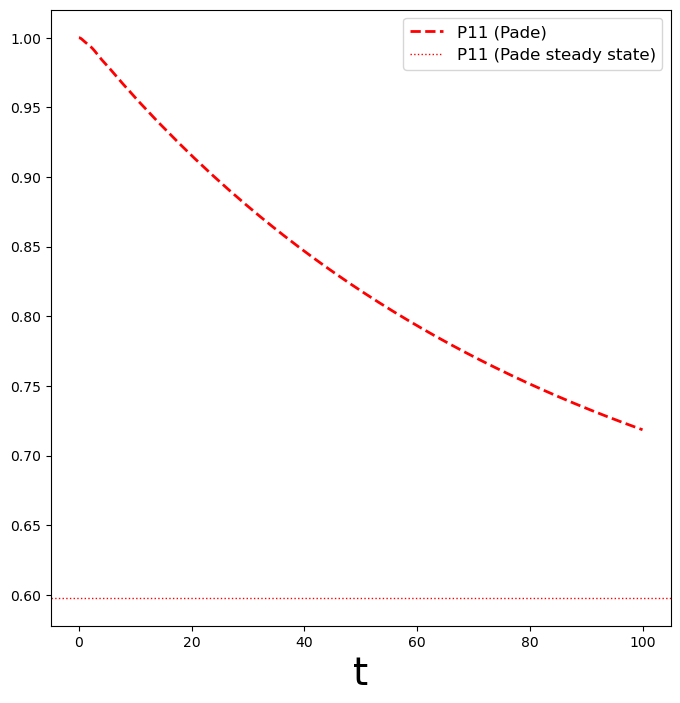

In [9]:
# Plot the Pade results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))

axes.plot(
    tlist, expect(result_pade.states, rho0),
    'r--', linewidth=2,
    label="P11 (Pade)",
)
axes.axhline(
    expect(rho_ss_pade, rho0),
    color='r', linestyle="dotted", linewidth=1,
    label="P11 (Pade steady state)",
)

axes.set_xlabel('t', fontsize=28)
axes.legend(fontsize=12);

Now let us do the same for the Matsubara expansion:

In [10]:
# HEOM dynamics using the Matsubara approximation:

envL_mats = envL.approx_by_matsubara(Nk=Nk, tag="L")
envR_mats = envR.approx_by_matsubara(Nk=Nk, tag="R")


with timer("RHS construction time"):
    solver_mats = HEOMSolver(
        H,
        [(envL_mats, bath_L.Q), (envR_mats, bath_R.Q)],
        max_depth=2,
        options=options,
    )

with timer("ODE solver time"):
    result_mats = solver_mats.run(rho0, tlist)

with timer("Steady state solver time"):
    rho_ss_mats, ado_ss_mats = solver_mats.steady_state()

RHS construction time: 0.09236598014831543
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.85s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.86s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.86s / Remaining 00:00:00:00

 Total run time:   0.86s
ODE solver time: 0.8649625778198242


Steady state solver time: 0.14136028289794922

We see a marked difference in the Matsubara vs Pade results:

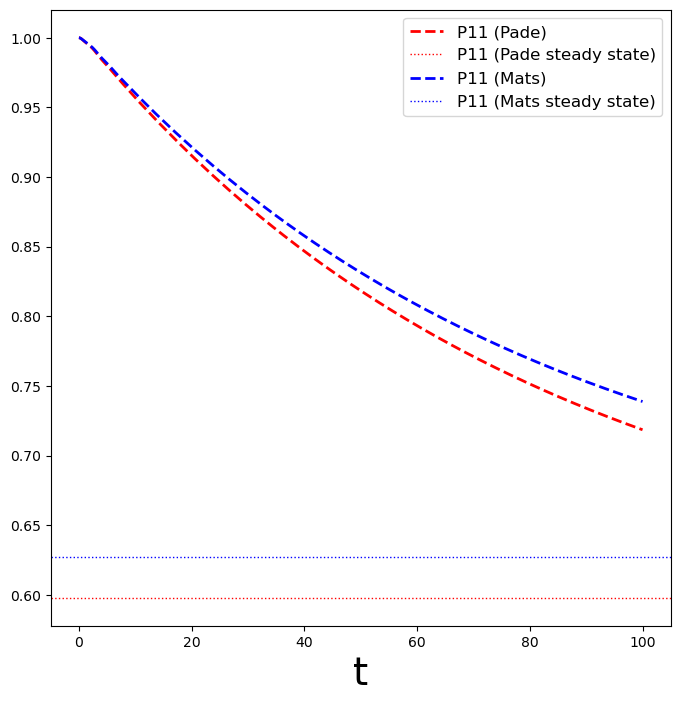

In [11]:
# Plot the Pade results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))

axes.plot(
    tlist, expect(result_pade.states, rho0),
    'r--', linewidth=2,
    label="P11 (Pade)",
)
axes.axhline(
    expect(rho_ss_pade, rho0),
    color='r', linestyle="dotted", linewidth=1,
    label="P11 (Pade steady state)",
)

axes.plot(
    tlist, expect(result_mats.states, rho0),
    'b--', linewidth=2,
    label="P11 (Mats)",
)
axes.axhline(
    expect(rho_ss_mats, rho0),
    color='b', linestyle="dotted", linewidth=1,
    label="P11 (Mats steady state)",
)

axes.set_xlabel('t', fontsize=28)
axes.legend(fontsize=12);

But which is more correct? The Matsubara or the Pade result?

One advantage of this simple model is that the steady state current to the baths is analytically solvable, so we can check convergence of the result by calculating it analytically (the sum of the currents to and from the system in the steady state must be zero, so the current from one bath is the same as the current to the other).

See the [QuTiP-BoFiN paper](https://arxiv.org/abs/2010.10806) for a detailed description and references for the analytic result. Below we just perform the required integration numerically.

In [12]:
def analytical_steady_state_current(bath_L, bath_R, e1):
    """ Calculate the analytical steady state current. """

    def integrand(w):
        return (2 / np.pi) * (
            bath_L.J(w) * bath_R.J(w) * (bath_L.fF(w) - bath_R.fF(w)) /
            (
                (bath_L.J(w) + bath_R.J(w))**2 +
                4 * (w - e1 - bath_L.lamshift(w) - bath_R.lamshift(w))**2
            )
        )

    def real_part(x):
        return np.real(integrand(x))

    def imag_part(x):
        return np.imag(integrand(x))

    # in principle the bounds for the integral should be rechecked if
    # bath or system parameters are changed substantially:
    bounds = [-10, 10]

    real_integral, _ = quad(real_part, *bounds)
    imag_integral, _ = quad(imag_part, *bounds)

    return real_integral + 1.0j * imag_integral


curr_ss_analytic = analytical_steady_state_current(bath_L, bath_R, e1)

print(f"Analytical steady state current: {curr_ss_analytic}")

Analytical steady state current: (0.0008130726698792024+0j)


To compare the analytical result above with the result from the HEOM, we need to be able to calculate the current from the system to the bath from the HEOM result. In the HEOM description, these currents are captured in the first level auxilliary density operators (ADOs).

In the function `state_current(...)` below, we extract the first level ADOs for the specified bath and sum the contributions to the current from each:

In [13]:
def state_current(ado_state, bath_tag):
    """ Determine current from the given bath (either "R" or "L") to
        the system in the given ADO state.
    """
    level_1_aux = [
        (ado_state.extract(label), ado_state.exps(label)[0])
        for label in ado_state.filter(level=1, tags=[bath_tag])
    ]

    def exp_sign(exp):
        return 1 if exp.type == exp.types["+"] else -1

    def exp_op(exp):
        return exp.Q if exp.type == exp.types["+"] else exp.Q.dag()

    return -1.0j * sum(
        exp_sign(exp) * (exp_op(exp) * aux).tr() for aux, exp in level_1_aux
    )

Now we can calculate the steady state currents from the Pade and Matsubara HEOM results:

In [14]:
curr_ss_pade_L = state_current(ado_ss_pade, "L")
curr_ss_pade_R = state_current(ado_ss_pade, "R")

print(f"Pade steady state current (L): {curr_ss_pade_L}")
print(f"Pade steady state current (R): {curr_ss_pade_R}")

Pade steady state current (L): (-0.0008130302805827116-1.3010426069826053e-18j)
Pade steady state current (R): (0.0008130302805827133+5.963111948670274e-19j)


In [15]:
curr_ss_mats_L = state_current(ado_ss_mats, "L")
curr_ss_mats_R = state_current(ado_ss_mats, "R")

print(f"Matsubara steady state current (L): {curr_ss_mats_L}")
print(f"Matsubara steady state current (R): {curr_ss_mats_R}")

Matsubara steady state current (L): (-0.0011018485316349584-1.0842021724855044e-18j)
Matsubara steady state current (R): (0.0011018485316349586-4.336808689942018e-19j)


Note that the currents from each bath balance as is required by the steady state, but the value of the current is different for the Pade and Matsubara results.

Now let's compare all three:

In [16]:
print(f"Pade current (R): {curr_ss_pade_R}")
print(f"Matsubara current (R): {curr_ss_mats_R}")
print(f"Analytical curernt: {curr_ss_analytic}")

Pade current (R): (0.0008130302805827133+5.963111948670274e-19j)
Matsubara current (R): (0.0011018485316349586-4.336808689942018e-19j)
Analytical curernt: (0.0008130726698792024+0j)


In this case we observe that the Pade approximation has converged more closely to the analytical current than the Matsubara.

The Matsubara result could be improved by increasing the number of terms retained in the Matsubara expansion (i.e. increasing `Nk`).

## Current as a function of bias voltage

Now lets plot the current as a function of bias voltage (the bias voltage is the parameter `theta` for the two baths).

We will calculate the steady state current for each `theta` both analytically and using the HEOM with the Pade correlation expansion approximation.

In [17]:
# Theta (bias voltages)

thetas = np.linspace(-4, 4, 100)

# Setup a progress bar:

progress = IntProgress(min=0, max=2 * len(thetas))
display(progress)

# Calculate the current for the list of thetas


def current_analytic_for_theta(e1, bath_L, bath_R, theta):
    """ Return the analytic current for a given theta. """
    current = analytical_steady_state_current(
        bath_L.replace(theta=theta),
        bath_R.replace(theta=theta),
        e1,
    )
    progress.value += 1
    return np.real(current)


def current_pade_for_theta(H, bath_L, bath_R, theta, Nk):
    """ Return the steady state current using the Pade approximation. """
    bath_L = bath_L.replace(theta=theta)
    bath_R = bath_R.replace(theta=theta)

    envL = LorentzianEnvironment(bath_L.T, bath_L.mu, bath_L.gamma, bath_L.W)
    bathL = envL.approx_by_pade(Nk=Nk)
    envR = LorentzianEnvironment(bath_R.T, bath_R.mu, bath_R.gamma, bath_R.W)

    bathR = envR.approx_by_pade(Nk=Nk, tag="R")

    solver_pade = HEOMSolver(
        H, [(bathL, bath_L.Q), (bathR, bath_R.Q)], max_depth=2, options=options
    )
    rho_ss_pade, ado_ss_pade = solver_pade.steady_state()
    current = state_current(ado_ss_pade, bath_tag="R")

    progress.value += 1
    return np.real(current)


curr_ss_analytic_thetas = [
    current_analytic_for_theta(e1, bath_L, bath_R, theta) for theta in thetas
]

# The number of expansion terms has been dropped to Nk=6 to speed
# up notebook execution. Increase to Nk=10 for more accurate results.
curr_ss_pade_theta = [
    current_pade_for_theta(H, bath_L, bath_R, theta, Nk=6) for theta in thetas
]

IntProgress(value=0, max=200)

Below we plot the results and see that even with `Nk=6`, the HEOM Pade approximation gives good results for the steady state current. Increasing `Nk` to `10` gives very accurate results.

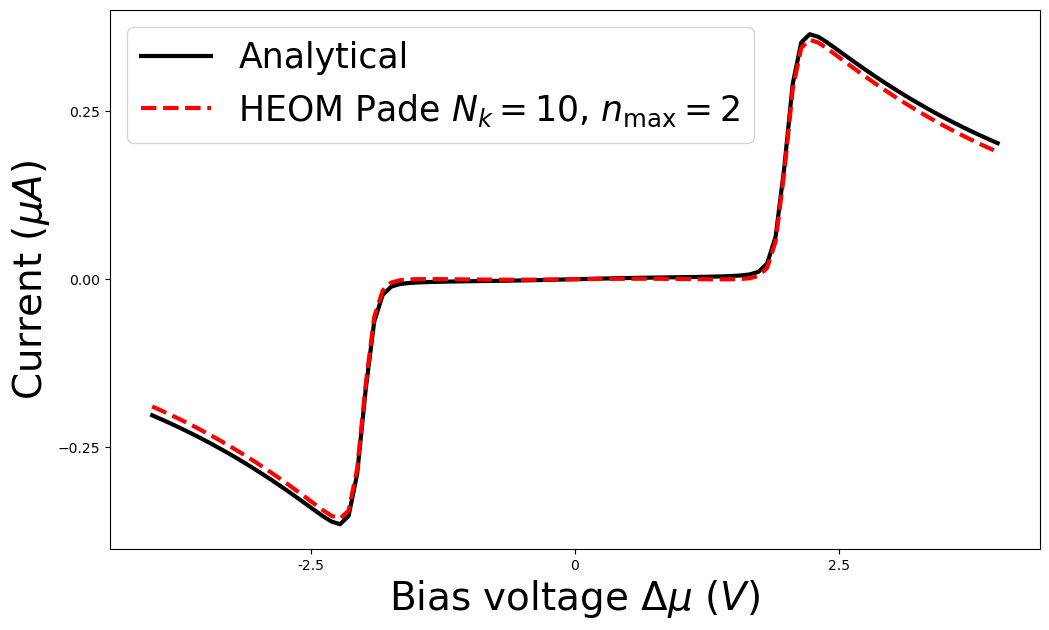

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(
    thetas, 2.434e-4 * 1e6 * np.array(curr_ss_analytic_thetas),
    color="black", linewidth=3,
    label=r"Analytical",
)
ax.plot(
    thetas, 2.434e-4 * 1e6 * np.array(curr_ss_pade_theta),
    'r--', linewidth=3,
    label=r"HEOM Pade $N_k=10$, $n_{\mathrm{max}}=2$",
)


ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)

ax.set_xticks([-2.5, 0, 2.5])
ax.set_xticklabels([-2.5, 0, 2.5])
ax.set_xlabel(r"Bias voltage $\Delta \mu$ ($V$)", fontsize=28)
ax.set_ylabel(r"Current ($\mu A$)", fontsize=28)
ax.legend(fontsize=25);

## About

In [19]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [20]:
assert np.allclose(curr_ss_pade_L + curr_ss_pade_R, 0)
assert np.allclose(curr_ss_mats_L + curr_ss_mats_R, 0)
assert np.allclose(curr_ss_pade_R, curr_ss_analytic, rtol=1e-4)